# 01. 텍스트 데이터 다루기
- IMDB 전체 데이터를 이용하여 학습 (사전 학습된 임베딩 사용 X)

### IMDB 원본 데이터 전처리하기

In [1]:
import os

imdb_dir = '../datasets/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
print('IMDB datasets load complete')

IMDB datasets load complete


### 데이터 토큰화

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # 100개 단어 이후는 버림
training_samples = 20000 # 훈련 샘플 20000개
validation_samples = 5000 # 검증 샘플 5000개
max_words = 10000 # 가장 빈도가 높은 1만개의 단어만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
seqences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'{len(word_index)}개의 고유한 토큰을 찾았습니다.')

88582개의 고유한 토큰을 찾았습니다.


In [3]:
data = pad_sequences(seqences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기 :', data.shape)
print('레이블 텐서의 크기 :', labels.shape)

데이터 텐서의 크기 : (25000, 100)
레이블 텐서의 크기 : (25000,)


In [4]:
# 데이터를 훈련 세트와 검증 세트로 분할
# 샘플이 순서대로 있기 때문에 shuffle
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

### 사전 훈련된 임베딩을 사용하지 않고 같은 모델 훈련하기
- 단어 임베딩을 사용하는 것보다 정확도가 높음
    - 단어 임베딩 사용 : 50% 중후반
    - 단어 임베딩 사용 X, 적은 데이터 : 53%
    - 단어 임베딩 사용 X, 많은 데이터 : 84%

In [5]:
embedding_dim = 100

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=10, batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
625/625 [==============================] - 3s 3ms/step - loss: 0.4353 - accuracy: 0.7847 - val_loss: 0.3368 - val_accuracy: 0.8538
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0917 - accuracy: 0.9690 - val_loss: 0.4907 - val_accuracy: 0.8242
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.5798 - val_accuracy: 0.8386
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 6.3834e-04 - accuracy: 1.0000 - val_loss: 0.6050 - val_accuracy: 0.8430
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 2.5879e-04 - accuracy: 1.0000 - val_loss: 0.6292 - val_accuracy: 0.8434
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 1.5144e-04 - accuracy: 1.0000 - val_loss: 0.6508 - val_accuracy: 0.8436
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 9.5747e-05 - accuracy: 1.0000 - val_loss: 0.6710 - val_accurac

In [11]:
model.save_weights('../models/imdb_model.h5')

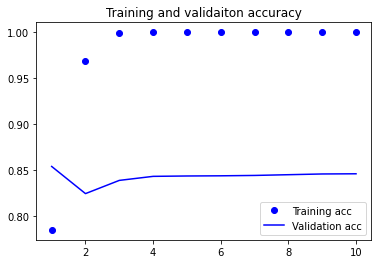

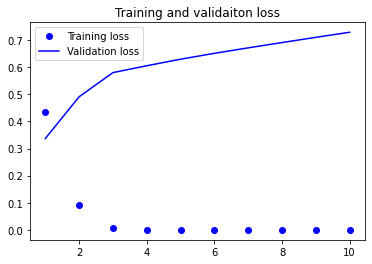

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validaiton accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validaiton loss')
plt.legend()

plt.show()

### 테스트 데이터 토큰화

In [9]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
print('IMDB datasets load complete')

IMDB datasets load complete


In [10]:
seqences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(seqences, maxlen=maxlen)
y_test = np.asarray(labels)

### 테스트 세트에서 모델 평가하기

In [12]:
model.load_weights('../models/imdb_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.7389 - accuracy: 0.8386


[0.7389249205589294, 0.8385999798774719]